# Barcelona Housing Prices (2018) — Exploratory Data Analysis (EDA)

This notebook focuses on **data understanding**: distributions, data quality, key relationships, and intuitive drivers of price.
It is intentionally **model-free** (the modeling story lives in `00_story_modeling.ipynb` and `scripts/train.py`).

**Note on missing values:** we **do not drop rows** because of missing values in columns that are *not* used in the EDA sections below.
For each specific plot/analysis, we only filter rows that are missing the *variables involved in that analysis*.

## 1) Setup

In [ ]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Project paths (adjust if needed)
PROJECT_ROOT = Path("..").resolve() if Path("..").exists() else Path(".").resolve()
DATA_PATH = PROJECT_ROOT / "data" / "raw" / "Barcelona_2018.csv"

TARGET = "PRICE"

# Features we focus on in EDA (aligned with the ML project narrative)
FEATURES_OF_INTEREST = [
    "CONSTRUCTEDAREA",
    "DISTANCE_TO_CITY_CENTER",
    "DISTANCE_TO_DIAGONAL",
    "ROOMNUMBER",
    "BATHNUMBER",
    "LATITUDE",
    "LONGITUDE",
    "CADASTRALQUALITYID",
    "HASPARKINGSPACE",
    "HASDOORMAN",
    "HASGARDEN",
]

### Why focus on a small set of features in the EDA?

You’ll notice we don’t explore *every* column in the raw dataset. That’s intentional.

- **EDA goal:** build intuition about the strongest price drivers and the data issues that matter most (missing values, outliers, encoding needs).
- **Domain-first selection:** in real estate, price is typically driven by **size**, **location**, **distance to points of interest**, **basic property configuration** (rooms/baths), and **amenities**.
- **Avoid low-signal / high-cardinality noise:** identifiers and very high-cardinality categorical fields can drown the narrative in plots without adding insight at this stage.
- **No leakage:** we avoid fields that could encode listing-specific artifacts or post-processing information.

**So what?** This compact feature set keeps the EDA readable and decision-oriented.  
The **modeling notebook** (`00_story_modeling.ipynb`) revisits feature inclusion more broadly and validates choices through cross-validation.


In [2]:
# Load data
# The dataset is semicolon-separated.
df = pd.read_csv(DATA_PATH, sep=";")

df.shape, df.columns.tolist()[:10]

((61486, 46),
 ['ASSETID',
  'PERIOD',
  'PRICE',
  'UNITPRICE',
  'ADTYPOLOGYID',
  'ADOPERATIONID',
  'CONSTRUCTEDAREA',
  'ROOMNUMBER',
  'BATHNUMBER',
  'HASTERRACE'])

## 2) Quick sanity checks

In [3]:
display(df.head(3))

,ASSETID,PERIOD,PRICE,UNITPRICE,ADTYPOLOGYID,ADOPERATIONID,CONSTRUCTEDAREA,ROOMNUMBER,BATHNUMBER,HASTERRACE,...,BUILTTYPEID_2,BUILTTYPEID_3,DISTANCE_TO_CITY_CENTER,DISTANCE_TO_METRO,DISTANCE_TO_DIAGONAL,LONGITUDE,LATITUDE,CITYNAME,ADTYPOLOGY,ADOPERATION
0,A11898131848556022319,201803,323000,3845.238095,HOME,SALE,84,4,1,1,...,0,1,1.876290,0.354004,1.475264,2.149566,41.380027,Barcelona,HOME,SALE
1,A18099432772155664747,201803,217000,2583.333333,HOME,SALE,84,3,2,0,...,0,1,2.118595,0.284372,1.194261,2.145689,41.381632,Barcelona,HOME,SALE
2,A2003099089407882787,201803,114000,1407.407407,HOME,SALE,81,2,1,0,...,1,0,4.127099,0.261574,2.504982,2.173891,41.423929,Barcelona,HOME,SALE


In [4]:
# Basic info
print("Rows, columns:", df.shape)
print("\nTarget dtype:", df[TARGET].dtype)
print("\nMissing values (total):", int(df.isna().sum().sum()))

Rows, columns: (61486, 46)

Target dtype: int64

Missing values (total): 34999


In [5]:
# Dtypes overview
dtype_counts = df.dtypes.value_counts()
display(dtype_counts)

int64      31
float64     9
object      6
Name: count, dtype: int64

In [6]:
# Duplicate rows (exact duplicates)
n_dups = df.duplicated().sum()
print("Exact duplicate rows:", int(n_dups))

Exact duplicate rows: 0


### Basic range checks (lightweight)

In [7]:
# We'll only check obvious invalid values; we do not drop anything globally here.
checks = {}

if TARGET in df.columns:
    checks["PRICE <= 0"] = int((df[TARGET] <= 0).sum())

if "CONSTRUCTEDAREA" in df.columns:
    checks["CONSTRUCTEDAREA <= 0"] = int((df["CONSTRUCTEDAREA"] <= 0).sum())

if "LATITUDE" in df.columns:
    checks["LATITUDE outside [-90, 90]"] = int(((df["LATITUDE"] < -90) | (df["LATITUDE"] > 90)).sum())

if "LONGITUDE" in df.columns:
    checks["LONGITUDE outside [-180, 180]"] = int(((df["LONGITUDE"] < -180) | (df["LONGITUDE"] > 180)).sum())

pd.DataFrame.from_dict(checks, orient="index", columns=["count"])

,count
PRICE <= 0,0
CONSTRUCTEDAREA <= 0,0
"LATITUDE outside [-90, 90]",0
"LONGITUDE outside [-180, 180]",0


## 3) Missingness overview

In [8]:
missing = df.isna().mean().sort_values(ascending=False)
missing_df = pd.DataFrame({
    "missing_pct": (missing * 100).round(2),
    "missing_count": df.isna().sum()
})

missing_nonzero = missing_df[missing_df["missing_count"] > 0]

if missing_nonzero.empty:
    print("✅ No missing values (NaN) detected in the dataset.")
else:
    display(missing_nonzero.head(20))


,missing_pct,missing_count
CONSTRUCTIONYEAR,37.36,22974
FLATLOCATIONID,12.64,7772
FLOORCLEAN,6.92,4253


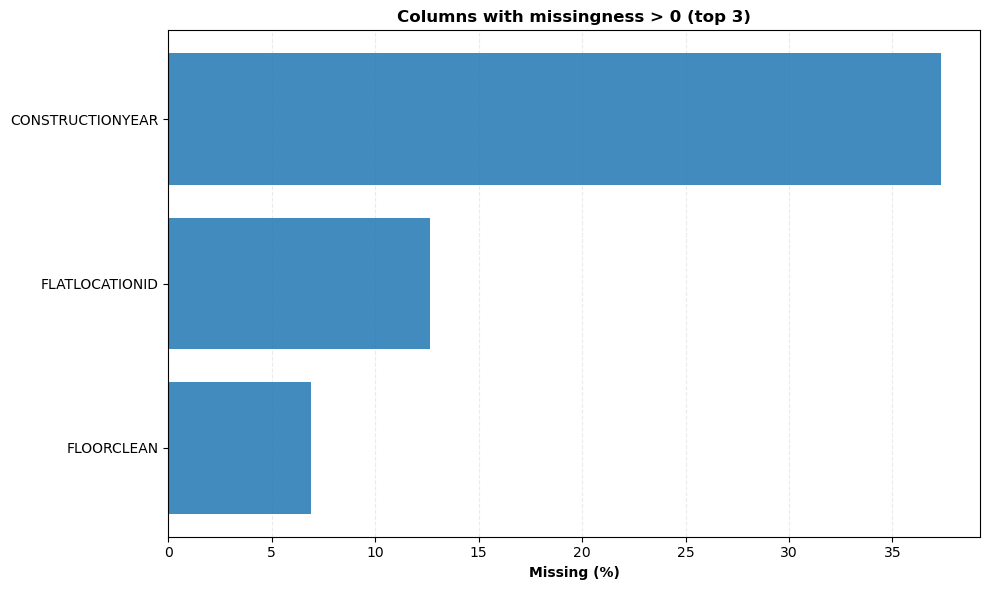

In [9]:
# Plot missingness (only columns with missing > 0)
if missing_nonzero.empty:
    print("✅ No columns with missingness > 0 to plot.")
else:
    topk = min(15, len(missing_nonzero))
    m = missing_nonzero.sort_values("missing_pct", ascending=True).tail(topk)

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.barh(m.index, m["missing_pct"], alpha=0.85)
    ax.set_title(f"Columns with missingness > 0 (top {topk})", fontweight="bold")
    ax.set_xlabel("Missing (%)", fontweight="bold")
    ax.grid(axis="x", alpha=0.25, linestyle="--")
    ax.set_axisbelow(True)
    fig.tight_layout()
    plt.show()


**This suggests…** missing values are concentrated in a small number of columns rather than spread across the dataset.  
**This motivates…** using **type-aware imputation** (numeric → median, categorical → `"Unknown"`) and optionally adding **missing indicators** in the modeling pipeline, instead of dropping rows globally.


**Missingness for features of interest** (used in the EDA below):

In [10]:
foi_present = [c for c in FEATURES_OF_INTEREST if c in df.columns]
missing_foi = df[foi_present + [TARGET]].isna().mean().sort_values(ascending=False) * 100
missing_foi = missing_foi.round(2)
missing_foi

CONSTRUCTEDAREA            0.0
DISTANCE_TO_CITY_CENTER    0.0
DISTANCE_TO_DIAGONAL       0.0
ROOMNUMBER                 0.0
BATHNUMBER                 0.0
LATITUDE                   0.0
LONGITUDE                  0.0
CADASTRALQUALITYID         0.0
HASPARKINGSPACE            0.0
HASDOORMAN                 0.0
HASGARDEN                  0.0
PRICE                      0.0
dtype: float64

## 4) Target deep dive: PRICE

In [11]:
# PRICE distribution (clip for readability)
price = df[TARGET].dropna().astype(float)

p99 = price.quantile(0.99)
p995 = price.quantile(0.995)

print("PRICE percentiles:")
display(price.quantile([0.5, 0.75, 0.9, 0.95, 0.99, 0.995]).to_frame("PRICE (€)"))

PRICE percentiles:


,PRICE (€)
0.500,325000.0
0.750,462000.0
0.900,695000.0
0.950,901000.0
0.990,1533000.0
0.995,1787000.0


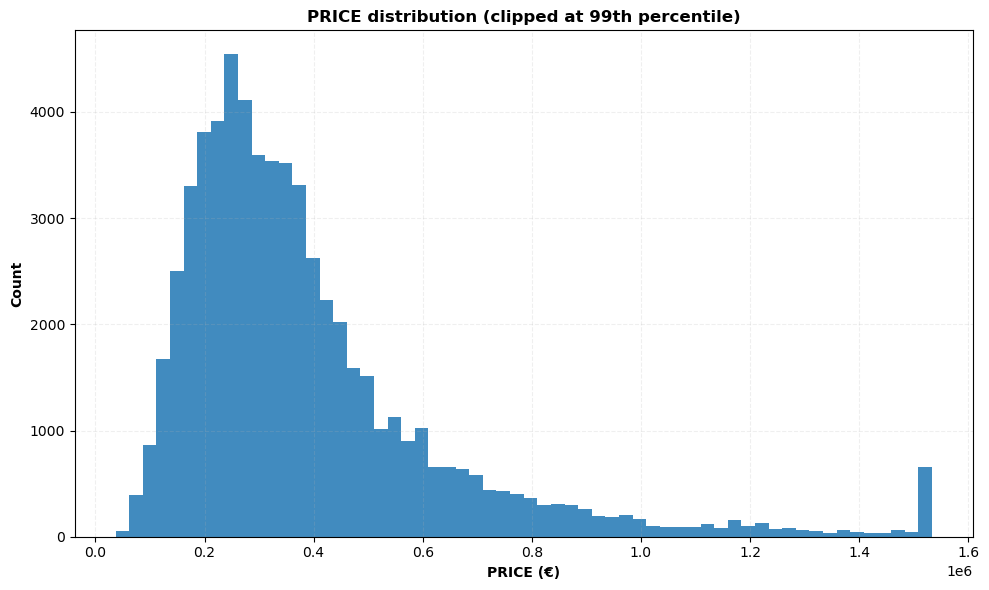

In [12]:
# Histogram (clipped at 99th percentile for readability)
price_clip = price.clip(upper=p99)

fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(price_clip, bins=60, alpha=0.85)
ax.set_title("PRICE distribution (clipped at 99th percentile)", fontweight="bold")
ax.set_xlabel("PRICE (€)", fontweight="bold")
ax.set_ylabel("Count", fontweight="bold")
ax.grid(alpha=0.2, linestyle="--")
fig.tight_layout()
plt.show()

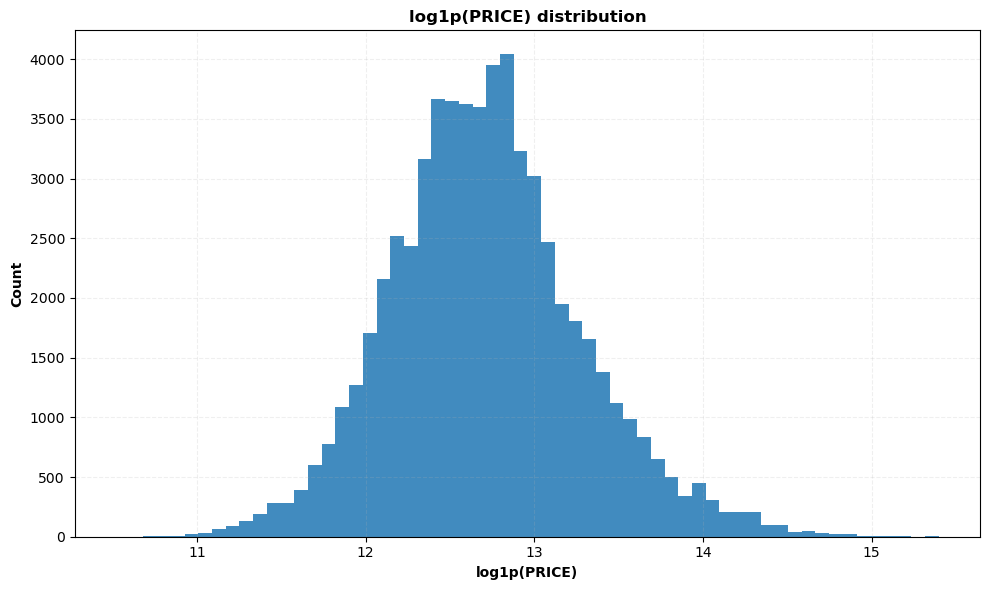

In [13]:
# Log1p distribution (helps to visualize long tails)
log_price = np.log1p(price)

fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(log_price, bins=60, alpha=0.85)
ax.set_title("log1p(PRICE) distribution", fontweight="bold")
ax.set_xlabel("log1p(PRICE)", fontweight="bold")
ax.set_ylabel("Count", fontweight="bold")
ax.grid(alpha=0.2, linestyle="--")
fig.tight_layout()
plt.show()

**This likely reflects…** the typical heavy right tail in housing prices (many “typical” listings and a small number of very expensive ones).  
**So what?** In modeling, a **log-transform** of `PRICE` (or robust losses/metrics) often improves stability and reduces the influence of extreme outliers.


## 5) Univariate EDA for key features
We keep this concise: a quick look at the *shape* and *typical range* of the main drivers.

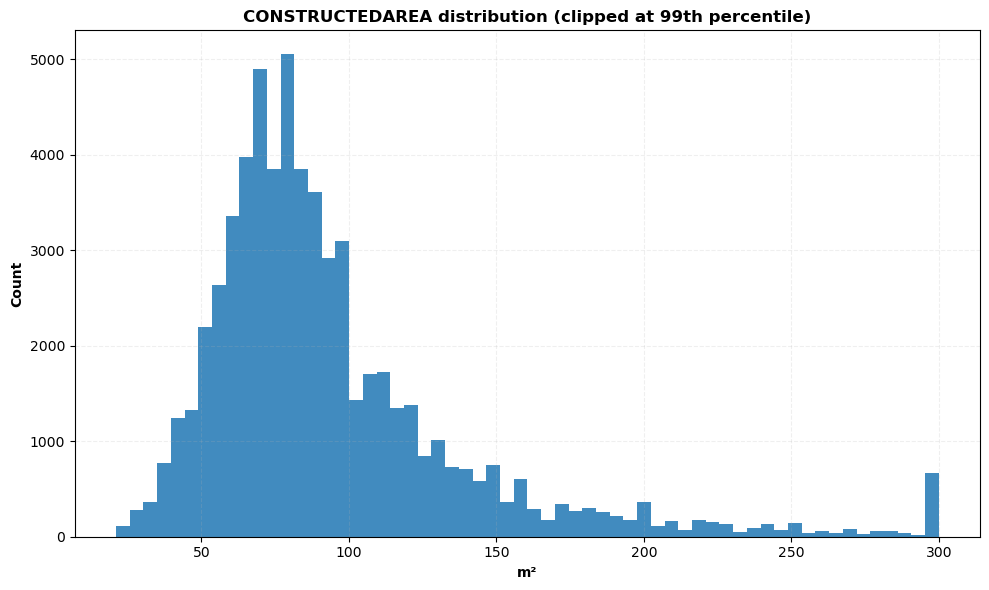

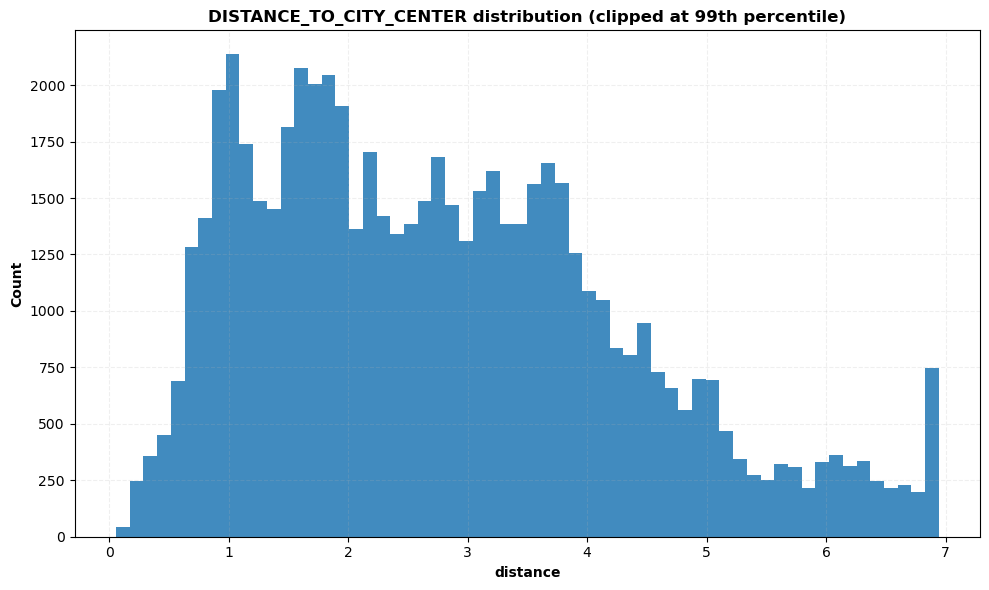

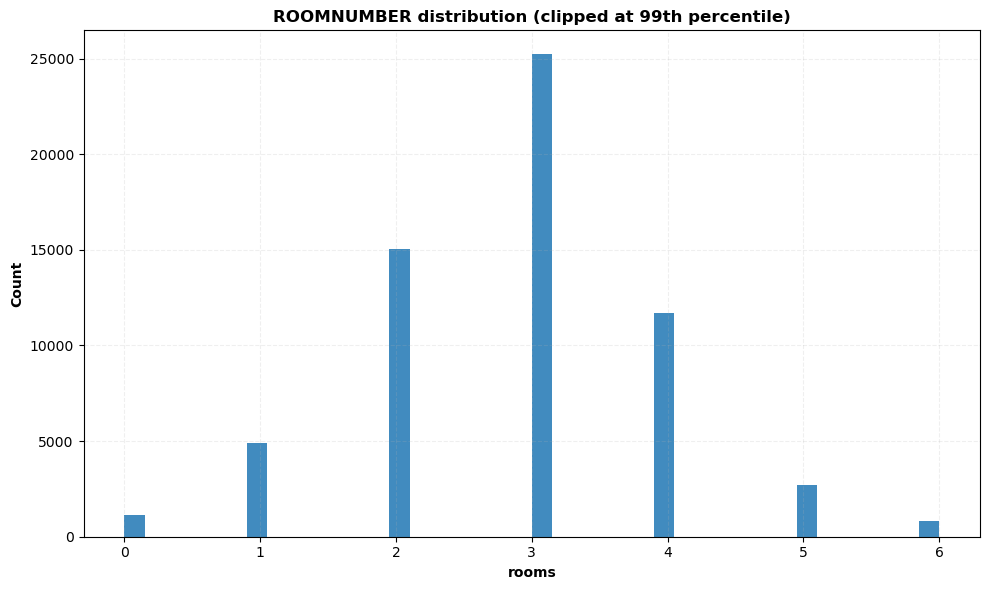

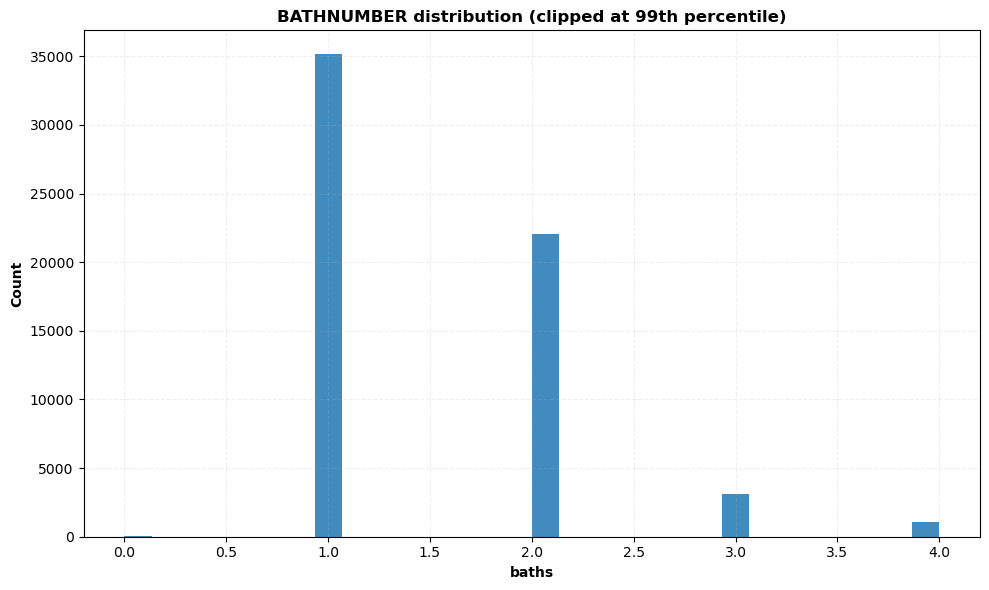

In [14]:
def hist_clip(series: pd.Series, title: str, xlabel: str, q: float = 0.99, bins: int = 60, figsize=(10,6)):
    s = series.dropna().astype(float)
    if len(s) == 0:
        print(f"[skip] No data for {title}")
        return
    upper = s.quantile(q)
    s = s.clip(upper=upper)
    fig, ax = plt.subplots(figsize=figsize)
    ax.hist(s, bins=bins, alpha=0.85)
    ax.set_title(f"{title} (clipped at {int(q*100)}th percentile)", fontweight="bold")
    ax.set_xlabel(xlabel, fontweight="bold")
    ax.set_ylabel("Count", fontweight="bold")
    ax.grid(alpha=0.2, linestyle="--")
    fig.tight_layout()
    plt.show()

hist_clip(df["CONSTRUCTEDAREA"], "CONSTRUCTEDAREA distribution", "m²")
hist_clip(df["DISTANCE_TO_CITY_CENTER"], "DISTANCE_TO_CITY_CENTER distribution", "distance")
hist_clip(df["ROOMNUMBER"], "ROOMNUMBER distribution", "rooms", q=0.995, bins=40)
hist_clip(df["BATHNUMBER"], "BATHNUMBER distribution", "baths", q=0.995, bins=30)

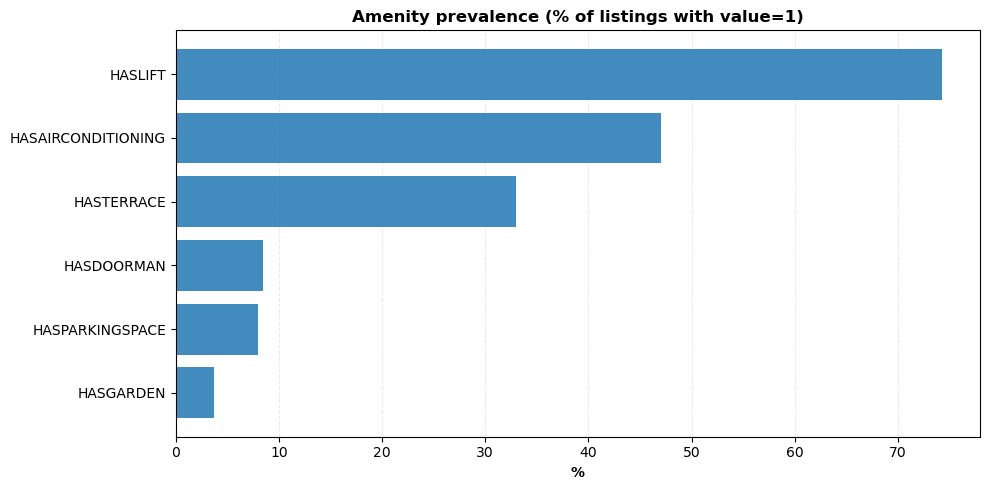

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Binary amenities: share of listings (robust)
bin_cols = [c for c in ["HASPARKINGSPACE", "HASDOORMAN", "HASGARDEN", "HASTERRACE", "HASLIFT", "HASAIRCONDITIONING"]
            if c in df.columns]

def to_binary(series: pd.Series) -> pd.Series:
    """Map common representations to 0/1; keep NaN as NaN."""
    s = series.copy()

    # If already numeric-ish: keep only 0/1, else NaN
    if pd.api.types.is_numeric_dtype(s):
        s = pd.to_numeric(s, errors="coerce")
        s = s.where(s.isin([0, 1]))
        return s

    # Otherwise normalize strings/booleans
    s = s.astype(str).str.strip().str.lower()
    mapping = {
        "1": 1, "0": 0,
        "true": 1, "false": 0,
        "yes": 1, "no": 0,
        "y": 1, "n": 0,
        "t": 1, "f": 0
    }
    s = s.map(mapping)
    return s

amen = {}
for c in bin_cols:
    s = to_binary(df[c]).dropna()
    if len(s) > 0:
        amen[c] = float((s == 1).mean() * 100)

amen_df = pd.DataFrame.from_dict(amen, orient="index", columns=["pct_true"]).sort_values("pct_true")

fig, ax = plt.subplots(figsize=(10, 5))
ax.barh(amen_df.index, amen_df["pct_true"], alpha=0.85)
ax.set_title("Amenity prevalence (% of listings with value=1)", fontweight="bold")
ax.set_xlabel("%", fontweight="bold")
ax.grid(axis="x", alpha=0.25, linestyle="--")
ax.set_axisbelow(True)
fig.tight_layout()
plt.show()


## 6) Bivariate relationships with PRICE
We focus on intuitive patterns and segment-level comparisons.

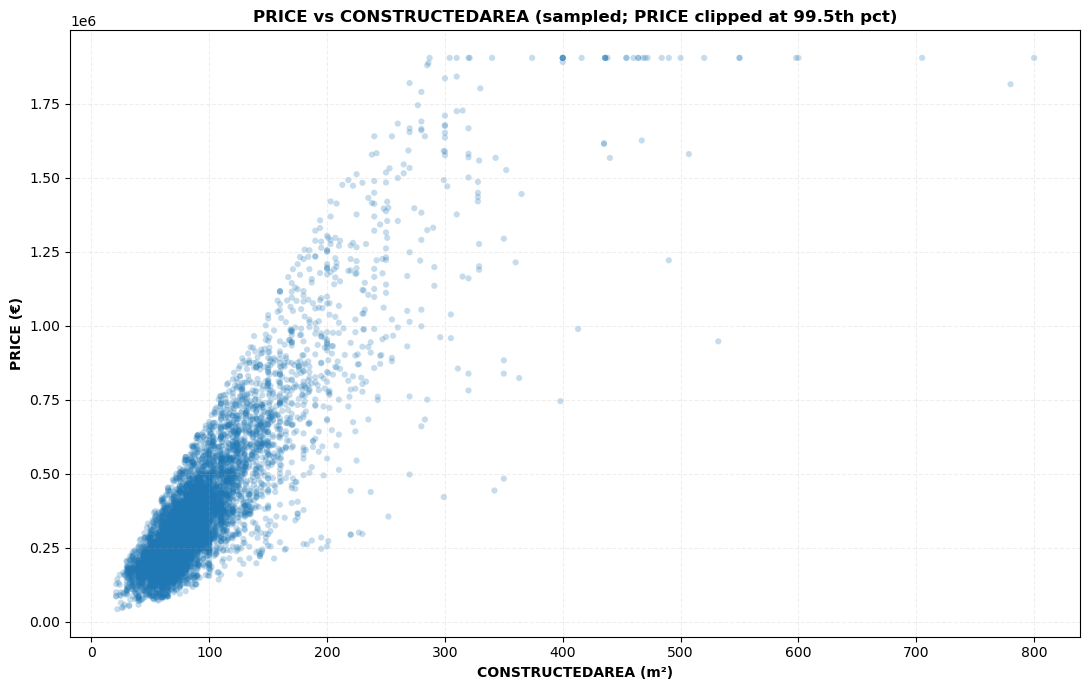

In [16]:
# Scatter: PRICE vs CONSTRUCTEDAREA (sampled for readability)
cols = ["CONSTRUCTEDAREA", TARGET]
tmp = df[cols].dropna().copy()

# sample to avoid heavy plots in notebooks
tmp = tmp.sample(n=min(7000, len(tmp)), random_state=42)

x = tmp["CONSTRUCTEDAREA"].astype(float)
y = tmp[TARGET].astype(float)

# clip extreme y for readability in scatter
y_clip = y.clip(upper=y.quantile(0.995))

fig, ax = plt.subplots(figsize=(11, 7))
ax.scatter(x, y_clip, s=20, alpha=0.25, edgecolors="none")
ax.set_title("PRICE vs CONSTRUCTEDAREA (sampled; PRICE clipped at 99.5th pct)", fontweight="bold")
ax.set_xlabel("CONSTRUCTEDAREA (m²)", fontweight="bold")
ax.set_ylabel("PRICE (€)", fontweight="bold")
ax.grid(alpha=0.2, linestyle="--")
fig.tight_layout()
plt.show()

**This suggests…** larger constructed area generally commands higher prices, but the spread widens at higher areas (heteroscedasticity).  
**This motivates…** trying models that handle **non-linearity** and **changing variance** (tree-based models) and/or using `log1p(PRICE)` for a more stable relationship.


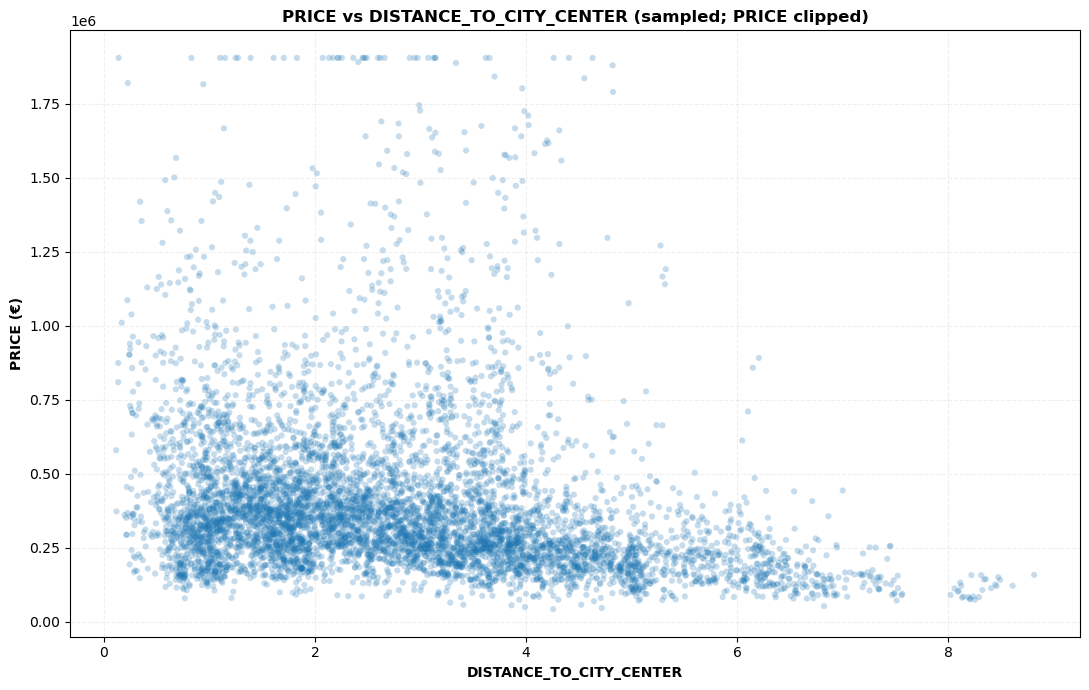

In [17]:
# Scatter: PRICE vs DISTANCE_TO_CITY_CENTER (sampled)
cols = ["DISTANCE_TO_CITY_CENTER", TARGET]
tmp = df[cols].dropna().copy()
tmp = tmp.sample(n=min(7000, len(tmp)), random_state=42)

x = tmp["DISTANCE_TO_CITY_CENTER"].astype(float)
y = tmp[TARGET].astype(float).clip(upper=tmp[TARGET].astype(float).quantile(0.995))

fig, ax = plt.subplots(figsize=(11, 7))
ax.scatter(x, y, s=20, alpha=0.25, edgecolors="none")
ax.set_title("PRICE vs DISTANCE_TO_CITY_CENTER (sampled; PRICE clipped)", fontweight="bold")
ax.set_xlabel("DISTANCE_TO_CITY_CENTER", fontweight="bold")
ax.set_ylabel("PRICE (€)", fontweight="bold")
ax.grid(alpha=0.2, linestyle="--")
fig.tight_layout()
plt.show()

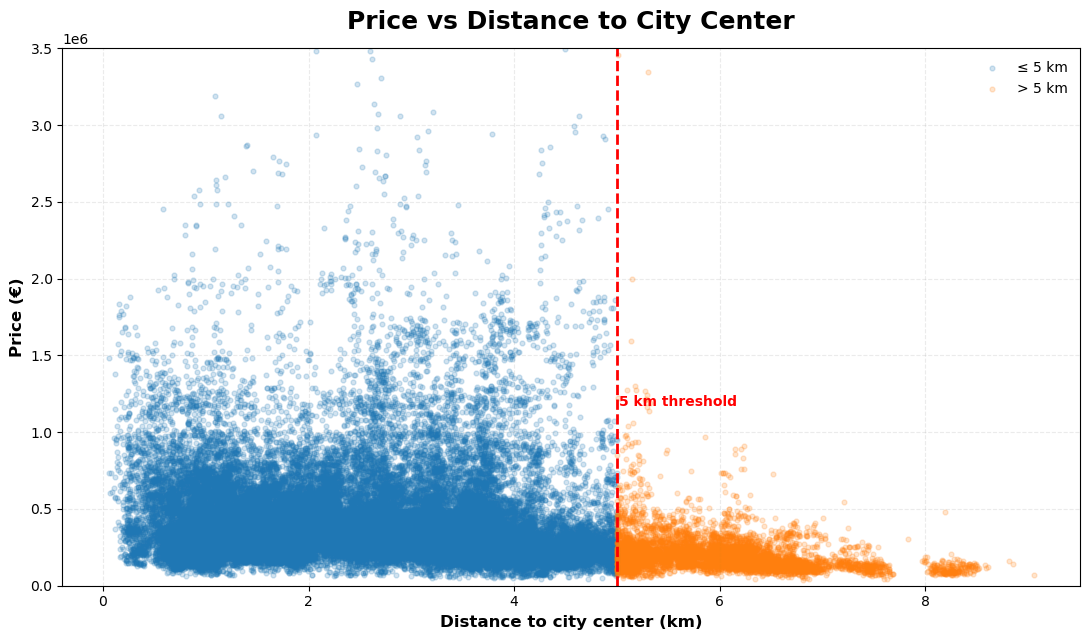

In [18]:
# --- PRICE vs DISTANCE_TO_CITY_CENTER (highlight 5 km threshold) ---
cols = ["DISTANCE_TO_CITY_CENTER", "PRICE"]
tmp = df[cols].dropna().copy()

df_near = tmp[tmp["DISTANCE_TO_CITY_CENTER"] <= 5]
df_far  = tmp[tmp["DISTANCE_TO_CITY_CENTER"] > 5]

fig, ax = plt.subplots(figsize=(11, 6.5))

ax.scatter(
    df_near["DISTANCE_TO_CITY_CENTER"], df_near["PRICE"],
    s=12, alpha=0.20, label="≤ 5 km"
)
ax.scatter(
    df_far["DISTANCE_TO_CITY_CENTER"], df_far["PRICE"],
    s=12, alpha=0.20, label="> 5 km"
)

ax.axvline(5, color="red", linestyle="--", linewidth=2)
ax.text(
    5.02, tmp["PRICE"].quantile(0.98),
    "5 km threshold",
    color="red", fontsize=10, fontweight="bold",
    va="top"
)

ax.set_title("Price vs Distance to City Center", fontsize=18, fontweight="bold", pad=14)
ax.set_xlabel("Distance to city center (km)", fontsize=12, fontweight="bold")
ax.set_ylabel("Price (€)", fontsize=12, fontweight="bold")
ax.set_ylim(0, 3_500_000)

ax.grid(True, alpha=0.25, linestyle="--")
ax.set_axisbelow(True)
ax.legend(frameon=False)

fig.tight_layout()
plt.show()


**This suggests…** proximity to the city center carries a clear price premium, and the relationship may not be purely linear (e.g., stronger effects within the first few kilometers).  
**This motivates feature X later…** engineered distance features (and potentially non-linear models) to capture diminishing returns with distance.


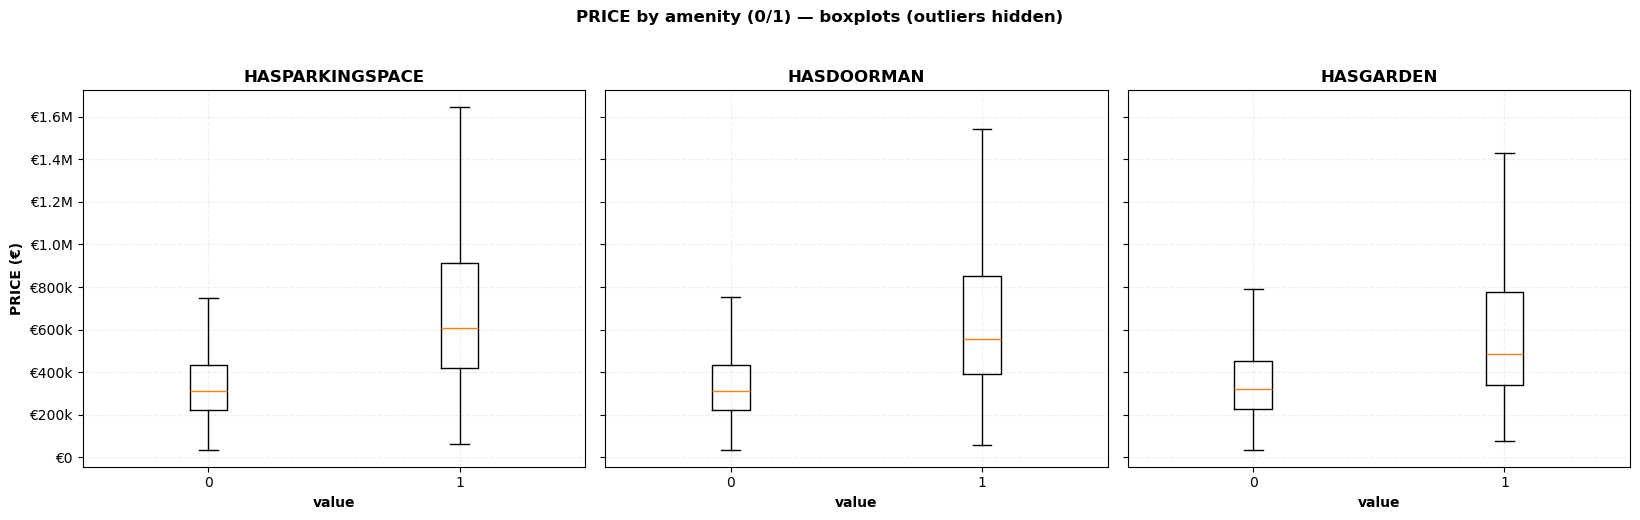

In [19]:
# Boxplots: PRICE by binary amenities (parking/doorman/garden)
from matplotlib.ticker import FuncFormatter

def euro_fmt(x, pos=None):
    if x >= 1_000_000:
        return f"€{x/1_000_000:.1f}M"
    if x >= 1_000:
        return f"€{x/1_000:.0f}k"
    return f"€{x:.0f}"

price_max = df[TARGET].dropna().astype(float).quantile(0.995)

amen_cols = [c for c in ["HASPARKINGSPACE", "HASDOORMAN", "HASGARDEN"] if c in df.columns]
fig, axes = plt.subplots(1, len(amen_cols), figsize=(5.5*len(amen_cols), 5), sharey=True)

if len(amen_cols) == 1:
    axes = [axes]

for ax, col in zip(axes, amen_cols):
    tmp = df[[col, TARGET]].dropna().copy()
    tmp[TARGET] = tmp[TARGET].astype(float).clip(upper=price_max)

    groups = [tmp.loc[tmp[col].astype(int)==0, TARGET].values,
              tmp.loc[tmp[col].astype(int)==1, TARGET].values]

    ax.boxplot(groups, tick_labels=["0", "1"], showfliers=False)
    ax.set_title(col, fontweight="bold")
    ax.set_xlabel("value", fontweight="bold")
    ax.grid(alpha=0.2, linestyle="--")
    ax.yaxis.set_major_formatter(FuncFormatter(euro_fmt))

axes[0].set_ylabel("PRICE (€)", fontweight="bold")
fig.suptitle("PRICE by amenity (0/1) — boxplots (outliers hidden)", fontweight="bold", y=1.03)
fig.tight_layout()
plt.show()

**This suggests…** these amenities are associated with a noticeable upward shift in the price distribution.  
**So what?** Keeping them as binary features is valuable, and their effect is often additive in linear models while providing clean splits in tree-based models.


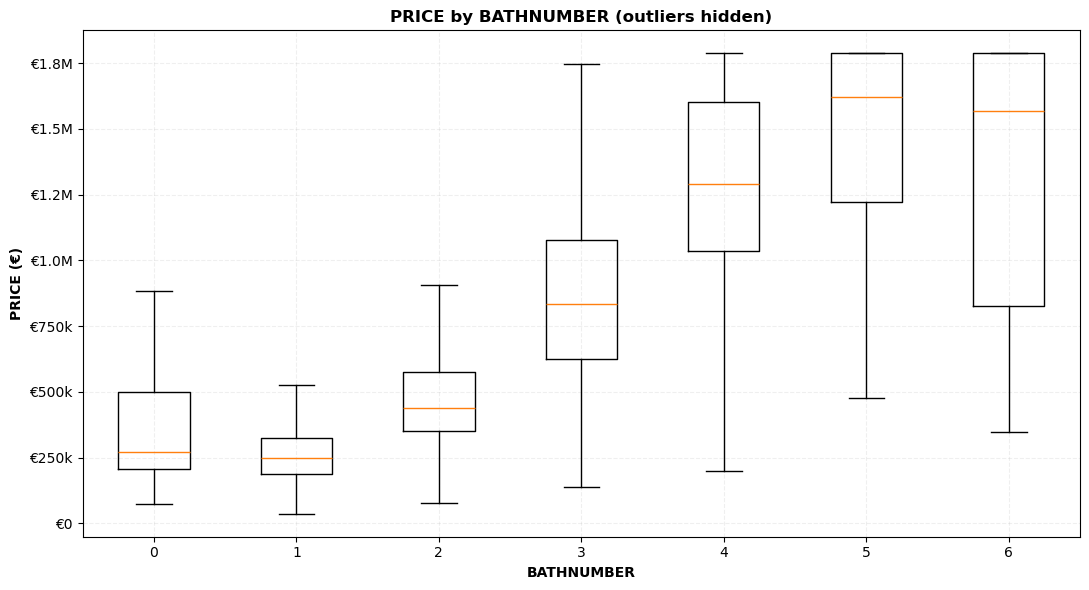

In [20]:
# PRICE by BATHNUMBER (boxplot)
tmp = df[["BATHNUMBER", TARGET]].dropna().copy()
tmp["BATHNUMBER"] = tmp["BATHNUMBER"].astype(int)
tmp[TARGET] = tmp[TARGET].astype(float).clip(upper=tmp[TARGET].astype(float).quantile(0.995))

# keep reasonable bath counts
tmp = tmp[tmp["BATHNUMBER"].between(0, 6)]

cats = sorted(tmp["BATHNUMBER"].unique())
data = [tmp.loc[tmp["BATHNUMBER"] == c, TARGET].values for c in cats]

fig, ax = plt.subplots(figsize=(11, 6))
ax.boxplot(data, tick_labels=[str(c) for c in cats], showfliers=False)
ax.set_title("PRICE by BATHNUMBER (outliers hidden)", fontweight="bold")
ax.set_xlabel("BATHNUMBER", fontweight="bold")
ax.set_ylabel("PRICE (€)", fontweight="bold")
ax.grid(alpha=0.2, linestyle="--")
ax.yaxis.set_major_formatter(FuncFormatter(euro_fmt))
fig.tight_layout()
plt.show()

**This likely reflects…** a step-wise relationship: more bathrooms tends to correspond to higher price brackets.  
**This motivates…** treating `BATHNUMBER` as an ordinal numeric feature (and optionally bucketing rare high counts if sample sizes are small).


## 7) Location quick view (LATITUDE/LONGITUDE)

A lightweight geo scatter can reveal strong spatial gradients.

**Limits (explicit):**
- This is **exploratory**: it helps us *see* whether location carries signal and whether coordinates look reasonable.
- We do **not** do clustering, geospatial feature engineering, or spatial modeling here (no geohash, no KMeans, no kriging, etc.).
- Any deeper geo work would belong to the **feature engineering + modeling** phase.

**So what?** If price gradients look strong, it motivates adding richer location features later (distance features, geo encoding, neighborhood grouping).  
Some of those ideas are connected to the modeling story in `00_story_modeling.ipynb`.


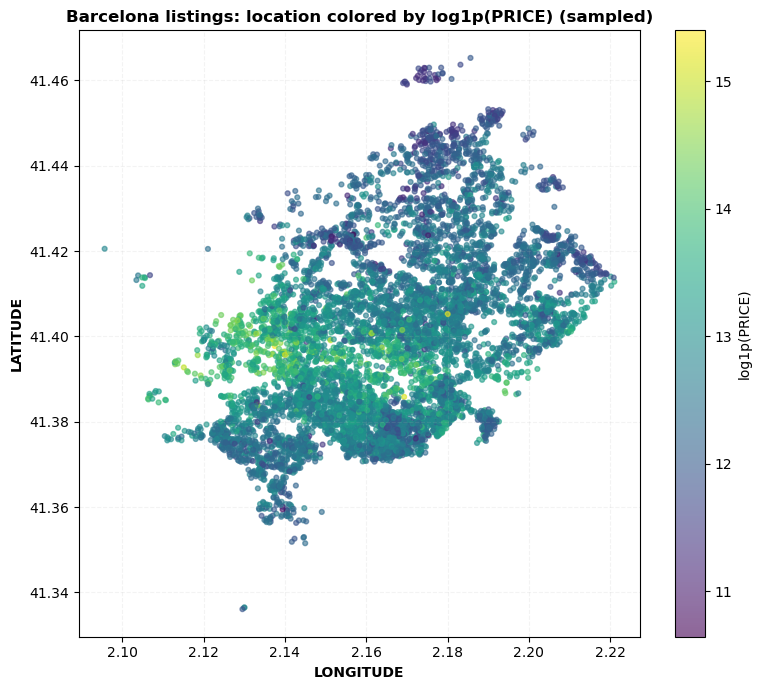

In [21]:
# Geo scatter (sampled), colored by log-price
cols = ["LONGITUDE", "LATITUDE", TARGET]
tmp = df[cols].dropna().copy().sample(n=min(9000, df[cols].dropna().shape[0]), random_state=42)

lon = tmp["LONGITUDE"].astype(float)
lat = tmp["LATITUDE"].astype(float)
c = np.log1p(tmp[TARGET].astype(float))

fig, ax = plt.subplots(figsize=(8, 7))
sc = ax.scatter(lon, lat, c=c, s=12, alpha=0.6)
ax.set_title("Barcelona listings: location colored by log1p(PRICE) (sampled)", fontweight="bold")
ax.set_xlabel("LONGITUDE", fontweight="bold")
ax.set_ylabel("LATITUDE", fontweight="bold")
fig.colorbar(sc, ax=ax, label="log1p(PRICE)")
ax.grid(alpha=0.15, linestyle="--")
fig.tight_layout()
plt.show()

## 8) Correlations (focused)
We compute correlations only for numeric variables and highlight the top drivers.

In [22]:
# Top correlations with PRICE (absolute)
numeric = df.select_dtypes(include=[np.number]).copy()
corr = numeric.corr(numeric_only=True)[TARGET].drop(TARGET).abs().sort_values(ascending=False)
top10 = corr.head(10)

display(top10.to_frame("abs_corr_with_PRICE"))

,abs_corr_with_PRICE
CONSTRUCTEDAREA,0.877605
BATHNUMBER,0.714820
UNITPRICE,0.539064
ROOMNUMBER,0.493531
CADASTRALQUALITYID,0.462450
DISTANCE_TO_DIAGONAL,0.397664
HASPARKINGSPACE,0.356745
ISPARKINGSPACEINCLUDEDINPRICE,0.356745
HASDOORMAN,0.308178
LONGITUDE,0.273003


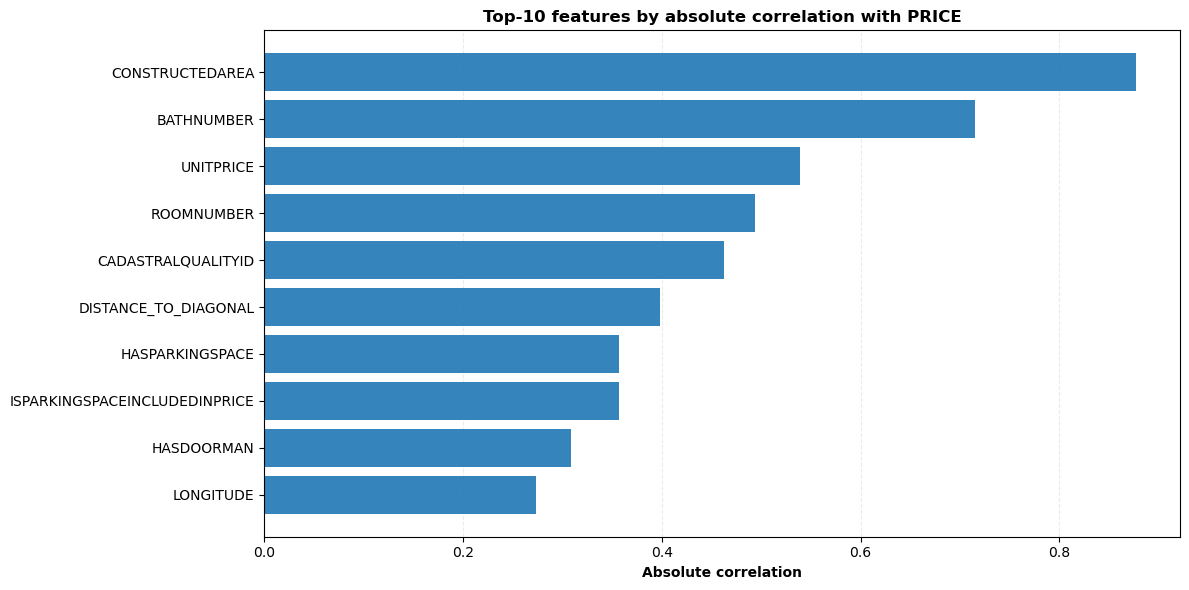

In [23]:
# Bar plot: top-10 abs correlation with PRICE
fig, ax = plt.subplots(figsize=(12, 6))
ax.barh(top10.index[::-1], top10.values[::-1], alpha=0.9)
ax.set_title("Top-10 features by absolute correlation with PRICE", fontweight="bold")
ax.set_xlabel("Absolute correlation", fontweight="bold")
ax.grid(axis="x", alpha=0.25, linestyle="--")
ax.set_axisbelow(True)
fig.tight_layout()
plt.show()

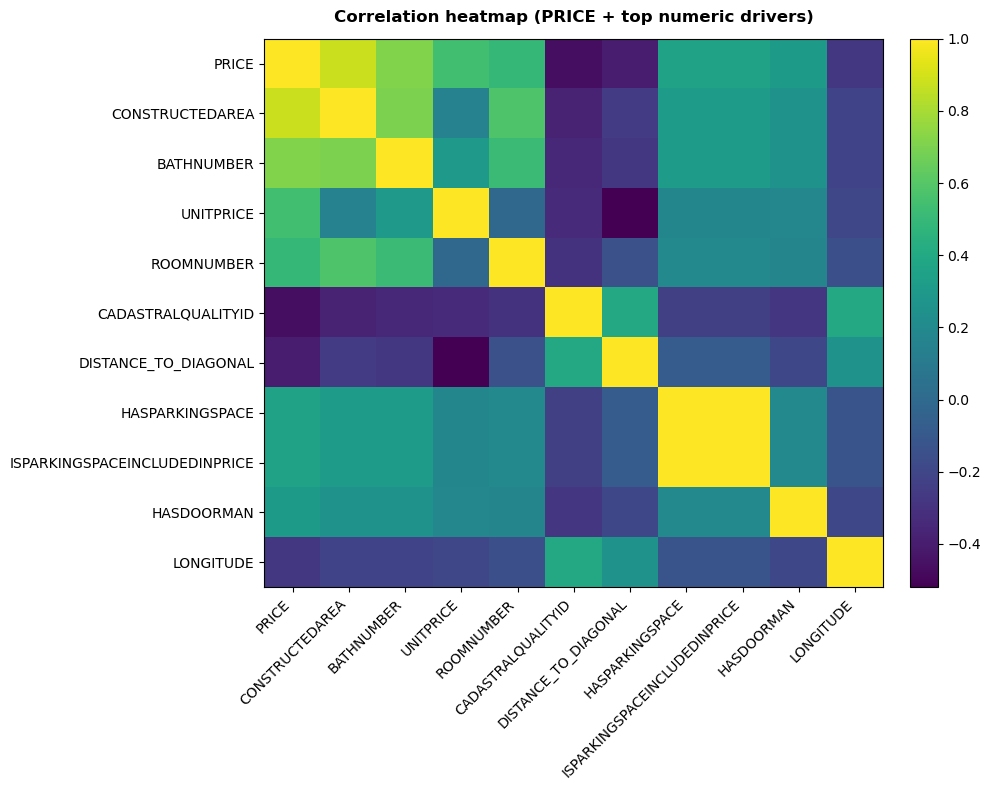

In [24]:
# Heatmap (focused): PRICE + top correlated numeric features
cols = [TARGET] + top10.index.tolist()
mat = numeric[cols].corr().values
labels = cols

fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(mat, aspect="auto")
ax.set_xticks(range(len(labels)))
ax.set_yticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=45, ha="right")
ax.set_yticklabels(labels)
ax.set_title("Correlation heatmap (PRICE + top numeric drivers)", fontweight="bold", pad=12)
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
fig.tight_layout()
plt.show()

**This suggests…** a small number of numeric drivers have strong *linear* association with `PRICE`.  
**Important:** correlation is only a quick triage (it misses non-linear effects and interactions), which is why we still validate feature value in the modeling notebook with cross-validation.


## 9) EDA takeaways (summary)
Below are concise, portfolio-friendly takeaways derived from the EDA above.

In [25]:
# A few computed takeaways to support narrative
takeaways = []
takeaways.append(f"Dataset size: {df.shape[0]:,} listings, {df.shape[1]} columns.")
takeaways.append(f"PRICE has a heavy right tail; log1p(PRICE) is closer to symmetric.")
takeaways.append("CONSTRUCTEDAREA shows a strong positive association with PRICE.")
takeaways.append("Location (LAT/LON) and distance-based features show clear gradients in price.")
takeaways.append("Amenities (parking/doorman/garden) show meaningful price separation in boxplots (median shifts).")

takeaways

['Dataset size: 61,486 listings, 46 columns.',
 'PRICE has a heavy right tail; log1p(PRICE) is closer to symmetric.',
 'CONSTRUCTEDAREA shows a strong positive association with PRICE.',
 'Location (LAT/LON) and distance-based features show clear gradients in price.',
 'Amenities (parking/doorman/garden) show meaningful price separation in boxplots (median shifts).']

### What I would do next (if extending EDA)

1) **Geo feature engineering (light → medium complexity)**  
   - Distance to key points / center(s), simple geo encoding (e.g., geohash)  
   - Optional: neighborhood grouping or lightweight clustering (only if it improves CV)

2) **Outliers and segment analysis**  
   - Outlier behavior by neighborhood/geo bins and by price bands (low / mid / high)  
   - Sensitivity checks: how much extreme prices influence metrics and model stability

3) **Feature interactions and richer representations**  
   - Interactions like area × location, typology × amenities  
   - If text fields exist (descriptions), explore a minimal NLP baseline (TF-IDF) as a “phase 2”

**Connection to modeling:** some of these ideas are partially explored in `00_story_modeling.ipynb` (and can be formalized in `scripts/train.py`).
